   # Artificial Neural Network with Pytorch 
   
   - Developed by **Armin Norouzi**
   - Compatible with Google Colaboratory- Pytorch version 1.12.1+cu113

   
   - **Objective:** Create full ANN model using batch normaliztion, dropout layer, and embeddings for both classification and regression problem and 
   
   
Table of content: 
- Adavnced ANN Model for Regression
- Adavnced ANN Model for Classification




# Adavnced ANN Model for Regression

The main data set for this section comes from <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>Kaggle competition</a>. In this notebook only reduced version of these data will be used.


In [119]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Loading data

The <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>Kaggle competition</a> provides a dataset with about 55 million records. The data contains only the pickup date & time, the latitude & longitude (GPS coordinates) of the pickup and dropoff locations, and the number of passengers. It is up to the contest participant to extract any further information. For instance, does the time of day matter? The day of the week? How do we determine the distance traveled from pairs of GPS coordinates?

For this exercise we've whittled the dataset down to just 120,000 records from April 11 to April 24, 2010. The records are randomly sorted. We'll show how to calculate distance from GPS coordinates, and how to create a pandas datatime object from a text column. This will let us quickly get information like day of the week, am vs. pm, etc.

Let's get started!

In [120]:
df = pd.read_csv('https://raw.githubusercontent.com/arminnorouzi/machine_learning_course_UofA_MECE610/main/Data/NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [121]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

From this we see that fares range from \\$2.50 to \\$49.90, with a mean of \\$10.04 and a median of \\$7.70

As this is a fare calculation, giving GPS longitudes and latitudes cannot gives us good feature. Instead, we can calculate distance between these two point. Let' do some feature engineering. 

## Feature Engineering

### Calculate the distance traveled
The <a href='https://en.wikipedia.org/wiki/Haversine_formula'>haversine formula</a> calculates the distance on a sphere between two sets of GPS coordinates.<br>
Here we assign latitude values with $\varphi$ (phi) and longitude with $\lambda$ (lambda).

The distance formula works out to

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

where

$\begin{split} r&: \textrm {radius of the sphere (Earth's radius averages 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes of point 1 and point 2}\\
\lambda_1, \lambda_2&: \textrm {longitudes of point 1 and point 2}\end{split}$

In [122]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """Calculates the haversine distance between 2 sets of GPS coordinates in df

    Arg:
        lat1 (str): latitudes column name of point 1 in df
        lat2 (str): latitudes column name of point 2 in df
        long1 (str): longitudes column name of point 1 in df
        long2 (str): longitudes column name of point 2 in df

    return:
        d (float): Traveled distance
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    # Converting to radians
    delta_phi = np.radians(df[lat2] - df[lat1])
    delta_lambda = np.radians(df[long2] - df[long1])
     
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d = (r * c) # in kilometers

    return d

In [123]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
 8   dist_km            120000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 8.2+ MB


### Add a datetime column and derive useful statistics

Date time in origina data base is just an object, let change to date time. Then we can extract information of time and date!

By creating a datetime object, we can extract information like "day of the week", "am vs. pm" etc. Note that the data was saved in UTC time. Our data falls in April of 2010 which occurred during Daylight Savings Time in New York. For that reason, we'll make an adjustment to EDT using UTC-4 (subtracting four hours).

In [125]:
# Change time to EST from UTC --> EDT: Eastern Day Time
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours = 4) 
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour'] < 12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
# df['Weekday'] = df['EDTdate'].dt.dayofweek # Give the integer of day of the week
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


### Handling categorical from continuous columns

We need to handle catagorical columns and continouous colums

In [126]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [127]:
# categorical columns
cat_cols = ['Hour', 'AMorPM', 'Weekday'] 

# continuous columns
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 
             'dropoff_longitude', 'passenger_count', 'dist_km'] 

# this column contains the labels - continuous as we are working on regression problem
y_col = ['fare_amount']  

Pandas offers a <a href='https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html'><strong>category dtype</strong></a> for converting categorical values to numerical codes. A dataset containing months of the year will be assigned 12 codes, one for each month. These will usually be the integers 0 to 11. Pandas replaces the column values with codes, and retains an index list of category values. In the steps ahead we'll call the categorical values "names" and the encodings "codes".

In [128]:
# Convert our three categorical columns to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [129]:
df['AMorPM']

0         am
1         am
2         am
3         pm
4         pm
          ..
119995    am
119996    am
119997    pm
119998    am
119999    pm
Name: AMorPM, Length: 120000, dtype: category
Categories (2, object): ['am', 'pm']

Now it is in catagory format!

We can access the category names with `Series.cat.categories` or just the codes with `Series.cat.codes`. This will make more sense if we look at `df['AMorPM']`:

In [130]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [131]:
df['AMorPM'].cat.codes

0         0
1         0
2         0
3         1
4         1
         ..
119995    0
119996    0
119997    1
119998    0
119999    1
Length: 120000, dtype: int8

<div class="alert alert-info"><strong>NOTE: </strong>NaN values in categorical data are assigned a code of -1. We don't have any in this particular dataset.</div>

Now we want to combine the three categorical columns into one input array using <a href='https://docs.scipy.org/doc/numpy/reference/generated/numpy.stack.html'><tt>numpy.stack</tt></a> We don't want the Series index, just the values.

In [132]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

# stacking hr ampm wkdy 
cats = np.stack([hr, ampm, wkdy], 1)

# printing first 5 elements
cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

<div class="alert alert-info"><strong>NOTE:</strong> This can be done in one line of code using a list comprehension:
<pre style='background-color:rgb(217,237,247)'>cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)</pre>

Don't worry about the dtype for now, we can make it int64 when we convert it to a tensor.</div>


### Convert numpy arrays to tensors

In [133]:
# Convert categorical variables to a tensor
cats = torch.tensor(cats, dtype=torch.int64) 
# this syntax is ok, since the source data is an array, not an existing tensor

cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

We can feed all of our continuous variables into the model as a tensor. Note that we're not normalizing the values here; we'll let the model perform this step.
<div class="alert alert-info"><strong>NOTE:</strong> We have to store <tt>conts</tt> and <tt>y</tt> as Float (float32) tensors, not Double (float64) in order for batch normalization to work properly.</div>

In [134]:
# Convert continuous variables to a tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.8641],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   7.2313]])

In [135]:
# Convert labels to a tensor
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)

y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

In [136]:
print(f" Catagorical data {cats.shape}, continuous data {conts.shape}, and label size {y.shape}")

 Catagorical data torch.Size([120000, 3]), continuous data torch.Size([120000, 6]), and label size torch.Size([120000, 1])


### Set an embedding size

The rule of thumb for determining the embedding size is to divide the number of unique entries in each column by 2, but not to exceed 50.


A simple lookup table that stores embeddings of a fixed dictionary and size.

This module is often used to store word embeddings and retrieve them using indices. The input to the module is a list of indices, and the output is the corresponding word embeddings.

- It's actually similar to one hot encoder

In [137]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

e.g., 24 is number of catagory an 12 is embedding dimention!

Let's see this embedding modoule with more detials

**Note:** This is only for illustration purpose and actuall embedding step will be defined inside model class

In [138]:
# This is our source data
catz = cats[:4]
catz

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3]])

In [139]:
# This is assigned inside the __init__() method
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [140]:
list(enumerate(selfembeds))

[(0, Embedding(24, 12)), (1, Embedding(2, 1)), (2, Embedding(7, 4))]

In [141]:
# This happens inside the forward() method
embeddingz = []
for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))
embeddingz

[tensor([[-1.2724, -0.1437,  2.9261,  0.0689,  0.4706, -0.2786, -0.5596,  2.3308,
           0.1885, -0.8100, -1.4231,  0.9814],
         [ 1.3138,  0.9308, -1.5881,  0.2968,  0.8028, -0.7855, -0.0857,  0.8060,
           0.6533, -0.7955,  0.9704,  1.3954],
         [ 0.3938,  0.0699,  0.7039,  0.4632,  0.8741,  1.0587, -1.9738, -0.4082,
          -0.6006, -0.4297,  0.9578,  0.0535],
         [ 1.7139,  0.1578, -0.7706, -1.2747, -0.3539, -0.4757,  0.2021,  0.5485,
           1.6894,  0.8605, -0.6032,  0.6775]], grad_fn=<EmbeddingBackward0>),
 tensor([[1.1740],
         [1.1740],
         [1.1740],
         [0.1529]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 1.3800,  1.0712,  0.4514, -0.1638],
         [-0.6869, -0.2217, -0.9965,  0.3544],
         [-0.6869, -0.2217, -0.9965,  0.3544],
         [ 0.4081, -2.0603, -0.9849, -0.3664]], grad_fn=<EmbeddingBackward0>)]

In [142]:
# We concatenate the embedding sections (12,1,4) into one (17)
z = torch.cat(embeddingz, 1)
z

tensor([[-1.2724, -0.1437,  2.9261,  0.0689,  0.4706, -0.2786, -0.5596,  2.3308,
          0.1885, -0.8100, -1.4231,  0.9814,  1.1740,  1.3800,  1.0712,  0.4514,
         -0.1638],
        [ 1.3138,  0.9308, -1.5881,  0.2968,  0.8028, -0.7855, -0.0857,  0.8060,
          0.6533, -0.7955,  0.9704,  1.3954,  1.1740, -0.6869, -0.2217, -0.9965,
          0.3544],
        [ 0.3938,  0.0699,  0.7039,  0.4632,  0.8741,  1.0587, -1.9738, -0.4082,
         -0.6006, -0.4297,  0.9578,  0.0535,  1.1740, -0.6869, -0.2217, -0.9965,
          0.3544],
        [ 1.7139,  0.1578, -0.7706, -1.2747, -0.3539, -0.4757,  0.2021,  0.5485,
          1.6894,  0.8605, -0.6032,  0.6775,  0.1529,  0.4081, -2.0603, -0.9849,
         -0.3664]], grad_fn=<CatBackward0>)

In [143]:
# This was assigned under the __init__() method
selfembdrop = nn.Dropout(.4)
z = selfembdrop(z)
z

tensor([[-2.1206, -0.2395,  4.8768,  0.1148,  0.7843, -0.4644, -0.9326,  0.0000,
          0.3142, -1.3500, -2.3719,  0.0000,  0.0000,  0.0000,  0.0000,  0.7524,
         -0.2730],
        [ 0.0000,  1.5514, -0.0000,  0.4946,  1.3380, -1.3091, -0.0000,  1.3434,
          0.0000, -1.3258,  1.6174,  0.0000,  0.0000, -1.1449, -0.0000, -1.6609,
          0.5907],
        [ 0.0000,  0.1165,  0.0000,  0.7720,  1.4568,  0.0000, -3.2897, -0.6803,
         -1.0010, -0.7162,  1.5963,  0.0892,  1.9566, -1.1449, -0.3694, -0.0000,
          0.0000],
        [ 0.0000,  0.2630, -1.2843, -2.1244, -0.0000, -0.7928,  0.0000,  0.0000,
          0.0000,  0.0000, -0.0000,  1.1292,  0.2549,  0.0000, -0.0000, -0.0000,
         -0.0000]], grad_fn=<MulBackward0>)

This is how the categorical embeddings are passed into the layers.

## Define a TabularModel
This somewhat follows the <a href='https://docs.fast.ai/tabular.models.html'>fast.ai library</a> The goal is to define a model based on the number of continuous columns (given by <tt>conts.shape[1]</tt>) plus the number of categorical columns and their embeddings (given by <tt>len(emb_szs)</tt> and <tt>emb_szs</tt> respectively). The output would either be a regression (a single float value), or a classification (a group of bins and their softmax values). For this exercise our output will be a single regression value. Note that we'll assume our data contains both categorical and continuous data. You can add boolean parameters to your own model class to handle a variety of datasets.

In [144]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p = 0.5):
        '''Extend the base Module class, set up the following parameters:
            
            emb_szs (list of tuples): each categorical variable size is paired with an embedding size
            n_cont (int): number of continuous variables
            out_sz (int): output size
            layers (list of ints): layer sizes
            p (float) dropout probability for each layer (for simplicity we'll use the same value throughout)
        '''
        super().__init__()

        # Set up the embedded layers with torch.nn.ModuleList() and torch.nn.Embedding()
        # Categorical data will be filtered through these Embeddings in the forward section.
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])

        # Set up a dropout function for the embeddings with torch.nn.Dropout() The default p-value=0.5
        self.emb_drop = nn.Dropout(p)

        # Set up a normalization function for the continuous variables with torch.nn.BatchNorm1d()
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Set up a sequence of neural network layers where each level includes a Linear function, 
        # an activation function (we'll use ReLU), a normalization step, and a dropout layer. 
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))

        # We'll combine the list of layers with torch.nn.Sequential()  
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        # Define the forward method. Preprocess the embeddings and normalize the continuous variables
        # before passing them through the layers.
        # Use torch.cat() to combine multiple tensors into one.
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        # combining catagorical and continuouse
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [145]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

### Define loss function & optimizer
PyTorch does not offer a built-in <a href='https://en.wikipedia.org/wiki/Root-mean-square_deviation'>RMSE Loss</a> function, and it would be nice to see this in place of MSE.<br>
For this reason, we'll simply apply the <tt>torch.sqrt()</tt> function to the output of MSELoss during training.

In [146]:
criterion = nn.MSELoss()  # we'll convert this to RMSE later
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Perform train/test splits
At this point our batch size is the entire dataset of 120,000 records. This will take a long time to train, so you might consider reducing this. We'll use 60,000. Recall that our tensors are already randomly shuffled.

In [147]:
batch_size = 60000
test_size = int(batch_size * .2)


cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [148]:
print(f"Size of cat size data {len(cat_train)} and Size of cat size data {len(con_train)}")

Size of cat size data 48000 and Size of cat size data 48000


## Train the model


In [149]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i += 1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss.detach().numpy())
    
    # a neat trick to save screen space:
    if i % 25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 12.56879330
epoch:  26  loss: 10.90198231
epoch:  51  loss: 10.23049927
epoch:  76  loss: 9.74855804
epoch: 101  loss: 9.19770336
epoch: 126  loss: 8.42278862
epoch: 151  loss: 7.40401649
epoch: 176  loss: 6.24063635
epoch: 201  loss: 5.04334021
epoch: 226  loss: 4.22978306
epoch: 251  loss: 3.89042974
epoch: 276  loss: 3.75080442
epoch: 300  loss: 3.72416544

Duration: 109 seconds


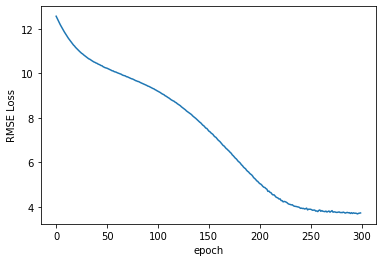

In [150]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

### Validate the model
Here we want to run the entire test set through the model, and compare it to the known labels.<br>
For this step we don't want to update weights and biases, so we set <tt>torch.no_grad()</tt>

In [151]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.63744378


This means that on average, predicted values are within &plusmn;$3.31 of the actual value.

Now let's look at the first 50 predicted values:

In [152]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.   4.3568   2.9000   1.4568
 2.  13.9365   5.7000   8.2365
 3.   6.5032   7.7000   1.1968
 4.  14.9225  12.5000   2.4225
 5.   6.1801   4.1000   2.0801
 6.   5.6820   5.3000   0.3820
 7.   5.0278   3.7000   1.3278
 8.  20.1617  14.5000   5.6617
 9.   9.2288   5.7000   3.5288
10.  12.6836  10.1000   2.5836
11.   8.0550   4.5000   3.5550
12.   1.5505   6.1000   4.5495
13.   6.7635   6.9000   0.1365
14.  11.1881  14.1000   2.9119
15.   4.6413   4.5000   0.1413
16.  32.1331  34.1000   1.9669
17.   1.3878  12.5000  11.1122
18.   6.5431   4.1000   2.4431
19.   7.2993   8.5000   1.2007
20.   4.1026   5.3000   1.1974
21.  14.8181  11.3000   3.5181
22.   9.6920  10.5000   0.8080
23.  17.5106  15.3000   2.2106
24.  16.8621  14.9000   1.9621
25.  46.2156  49.5700   3.3544
26.   2.2131   5.3000   3.0869
27.   4.2330   3.7000   0.5330
28.   5.2401   6.5000   1.2599
29.  14.8781  14.1000   0.7781
30.   6.2086   4.9000   1.3086
31.   3.9871   3.7000   0.2871
32.  31.

### Save the model
We can save a trained model to a file in case we want to come back later and feed new data through it. The best practice is to save the state of the model (weights & biases) and not the full definition. Also, we want to ensure that only a trained model is saved, to prevent overwriting a previously saved model with an untrained one.<br>For more information visit <a href='https://pytorch.org/tutorials/beginner/saving_loading_models.html'>https://pytorch.org/tutorials/beginner/saving_loading_models.html</a>

In [153]:
# Make sure to save the model only after the training has happened!
if len(losses) == epochs:
    torch.save(model.state_dict(), 'TaxiFareRegrModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

### Loading a saved model (starting from scratch)
We can load the trained weights and biases from a saved model. If we've just opened the notebook, we'll have to run standard imports and function definitions. To demonstrate, restart the kernel before proceeding.

In [154]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

def haversine_distance(df, lat1, long1, lat2, long2):
    r = 6371
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return r * c

class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        self.layers = nn.Sequential(*layerlist)
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        return self.layers(x)

Now define the model. Before we can load the saved settings, we need to instantiate our TabularModel with the parameters we used before (embedding sizes, number of continuous columns, output size, layer sizes, and dropout layer p-value). 

In [155]:
emb_szs = [(24, 12), (2, 1), (7, 4)]
model2 = TabularModel(emb_szs, 6, 1, [200,100], p=0.4)

Once the model is set up, loading the saved settings is a snap.

In [156]:
model2.load_state_dict(torch.load('TaxiFareRegrModel.pt'));
model2.eval() # be sure to run this step!

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

Next we'll define a function that takes in new parameters from the user, performs all of the preprocessing steps above, and passes the new data through our trained model.

In [157]:
def test_data(mdl): # pass in the name of the new model
    # INPUT NEW DATA
    plat = float(input('What is the pickup latitude?  '))
    plong = float(input('What is the pickup longitude? '))
    dlat = float(input('What is the dropoff latitude?  '))
    dlong = float(input('What is the dropoff longitude? '))
    psngr = int(input('How many passengers? '))
    dt = input('What is the pickup date and time?\nFormat as YYYY-MM-DD HH:MM:SS     ')
    
    # PREPROCESS THE DATA
    dfx_dict = {'pickup_latitude':plat,'pickup_longitude':plong,'dropoff_latitude':dlat,
         'dropoff_longitude':dlong,'passenger_count':psngr,'EDTdate':dt}
    dfx = pd.DataFrame(dfx_dict, index=[0])
    dfx['dist_km'] = haversine_distance(dfx,'pickup_latitude', 'pickup_longitude',
                                        'dropoff_latitude', 'dropoff_longitude')
    dfx['EDTdate'] = pd.to_datetime(dfx['EDTdate'])
    
    # We can skip the .astype(category) step since our fields are small,
    # and encode them right away
    dfx['Hour'] = dfx['EDTdate'].dt.hour
    dfx['AMorPM'] = np.where(dfx['Hour']<12,0,1) 
    dfx['Weekday'] = dfx['EDTdate'].dt.strftime("%a")
    dfx['Weekday'] = dfx['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
                                            [0,1,2,3,4,5,6]).astype('int64')
    # CREATE CAT AND CONT TENSORS
    cat_cols = ['Hour', 'AMorPM', 'Weekday']
    cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                 'dropoff_longitude', 'passenger_count', 'dist_km']
    xcats = np.stack([dfx[col].values for col in cat_cols], 1)
    xcats = torch.tensor(xcats, dtype=torch.int64)
    xconts = np.stack([dfx[col].values for col in cont_cols], 1)
    xconts = torch.tensor(xconts, dtype=torch.float)
    
    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(xcats, xconts)
    print(f'\nThe predicted fare amount is ${z.item():.2f}')

In [158]:
z = test_data(model2)

What is the pickup latitude?  40.5
What is the pickup longitude? -73.9
What is the dropoff latitude?  40.52
What is the dropoff longitude? -73.92
How many passengers? 2
What is the pickup date and time?
Format as YYYY-MM-DD HH:MM:SS     2010-04-15 16:00:00

The predicted fare amount is $16.81


# Adavnced ANN Model for Classification

All the feature engineering steps are same and the only diffferent is output layer:


In [159]:
torch.manual_seed(33)
model_classification = TabularModel(emb_szs, conts.shape[1], 2, [200,100], p=0.4) # out_sz = 2

In [160]:
model_classification

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

## Data processing 

Only we need to change labels:

In [161]:
y_col_classification = ['fare_class']  # this column contains the labels
y_classification = torch.tensor(df[y_col_classification].values).flatten()


batch_size = 60000
test_size = 12000

cat_train_classification = cats[:batch_size-test_size]
cat_test_classification = cats[batch_size-test_size:batch_size]
con_train_classification = conts[:batch_size-test_size]
con_test_classification = conts[batch_size-test_size:batch_size]


y_train_classification = y_classification[:batch_size-test_size]
y_test_classification = y_classification[batch_size-test_size:batch_size]

## Define loss function & optimizer
For our classification we'll replace the MSE loss function with <a href='https://pytorch.org/docs/stable/nn.html#crossentropyloss'><strong><tt>torch.nn.CrossEntropyLoss()</tt></strong></a><br>
For the optimizer, we'll continue to use <a href='https://pytorch.org/docs/stable/optim.html#torch.optim.Adam'><strong><tt>torch.optim.Adam()</tt></strong></a>

In [162]:
criterion_classification = nn.CrossEntropyLoss()
optimizer_classification = torch.optim.Adam(model_classification.parameters(), lr=0.001)

## Train the model

In [163]:
import time
start_time = time.time()

epochs = 300
losses_classification = []

for i in range(epochs):
    i += 1
    y_pred = model_classification(cat_train_classification, con_train_classification)
    loss = criterion_classification(y_pred, y_train_classification)
    losses_classification.append(loss.detach().numpy())
    
    # a neat trick to save screen space:
    if i % 25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer_classification.zero_grad()
    loss.backward()
    optimizer_classification.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 0.82952189
epoch:  26  loss: 0.37736836
epoch:  51  loss: 0.33777553
epoch:  76  loss: 0.31335571
epoch: 101  loss: 0.30397308
epoch: 126  loss: 0.29265368
epoch: 151  loss: 0.28549224
epoch: 176  loss: 0.28348288
epoch: 201  loss: 0.27752888
epoch: 226  loss: 0.27047357
epoch: 251  loss: 0.26466238
epoch: 276  loss: 0.26237664
epoch: 300  loss: 0.25767437

Duration: 111 seconds


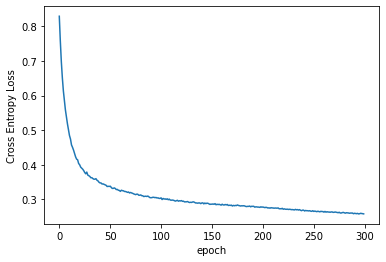

In [164]:
plt.plot(range(epochs), losses_classification)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

### Validate the model

In [165]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model_classification(cat_test_classification, con_test_classification)
    loss = criterion_classification(y_val, y_test_classification)
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.25234315


In [166]:
rows = 50
correct = 0
print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_test_classification[i]:^7}')
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

MODEL OUTPUT               ARGMAX  Y_TEST
tensor([ 2.4450, -2.0916])    0      0   
tensor([-3.1073,  3.0319])    1      0   
tensor([ 2.0243, -1.4779])    0      0   
tensor([-1.2340,  1.3499])    1      1   
tensor([ 2.3575, -1.7278])    0      0   
tensor([ 2.0867, -1.8267])    0      0   
tensor([ 1.7442, -1.2380])    0      0   
tensor([-1.7529,  0.9522])    1      1   
tensor([ 3.1390, -1.1189])    0      0   
tensor([-1.6066,  0.3667])    1      1   
tensor([ 2.1196, -1.5655])    0      0   
tensor([ 1.4812, -2.0972])    0      0   
tensor([ 1.2838, -1.2559])    0      0   
tensor([-2.0156,  1.3108])    1      1   
tensor([ 2.7361, -1.6540])    0      0   
tensor([-4.0747,  2.8859])    1      1   
tensor([ 2.3477, -1.9522])    0      1   
tensor([ 2.3716, -1.3114])    0      0   
tensor([ 0.9672, -0.6830])    0      0   
tensor([ 1.8338, -2.1560])    0      0   
tensor([-2.4573,  2.2303])    1      1   
tensor([-0.4080,  0.0718])    1      1   
tensor([-2.1369,  1.6939])    1   

## References: 

- [PyTorch for Deep Learning with Python Bootcamp](https://www.udemy.com/course/pytorch-for-deep-learning-with-python-bootcamp/) by [Jose Marcial Portilla](https://www.linkedin.com/in/jmportilla/)